In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import itertools
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


from scipy.stats import randint, uniform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV




In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Import Datasets

**IMDb Data**

In [4]:
aka = pd.read_csv('/content/drive/MyDrive/IMDB/title.akas.tsv/data.tsv',sep='\t',low_memory=False)
principals = pd.read_csv('/content/drive/MyDrive/IMDB/title.principals.tsv/data.tsv',sep='\t',low_memory=False)
name_basic = pd.read_csv('/content/drive/MyDrive/IMDB/name.basics.tsv/data.tsv',sep='\t' )
title_basic = pd.read_csv('/content/drive/MyDrive/IMDB/title.basics.tsv/data.tsv',sep='\t' )
crew = pd.read_csv('/content/drive/MyDrive/IMDB/title.crew.tsv/data.tsv',sep='\t' )
epi = pd.read_csv('/content/drive/MyDrive/IMDB/title.episode.tsv/data.tsv',sep='\t' )
rating = pd.read_csv('/content/drive/MyDrive/IMDB/title.ratings.tsv/data.tsv',sep='\t' )

<ipython-input-4-0a8abb9e311d>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basic = pd.read_csv('/content/drive/MyDrive/IMDB/title.basics.tsv/data.tsv',sep='\t' )


**Extra Data Scraped From Tmdb Api**

* The code to scrap tmdb data is attached in appendix 1.


* Here we directly load scraped data.

In [6]:
tmdb=pd.read_csv('/content/drive/MyDrive/IMDB/tmdb.csv',sep=',',engine='python',encoding = 'unicode_escape')

# **Assumptions**

#1) Here we made some basic and important assumptions:



**1. Average rating of a movie is a estimate of its objective quality**
* For each movie, there should exist a quantifiable, fixed, and objective measure of its quality.
* On IMDb, people can score movies they like or dislike on a scale of from 1 to 10 (ref: wikipedia). Every individual rating is subjective, thus the rating could be biased given different audience segmentation.
* IMDb is launched in 1990, and all the IMDb ratings are given after that. When people who lives in the late 20th century and 21 century rate a movie that is produced long time ago, the rating is probably biased since they are rating old movies with aesthetic standard of post-1990. (which is unfair)
* The average rating of a movie, given enough votes, would statistically reveal the objective quanlity of the movie. However, if the a movie doesn't receive enough votes, its voting results would be highly random and lose statistical significance.
* In summary, the IMDb average rating of a movie is a biased estimate of its quality. There is a lot of factors that could affect the quality of a movie,and we want to train a model the capture such correlations.

**2. Causality between a factor and movie quality:**

* The objective quanlity of a movie is a quantifiable number, and it's fixed after release. Any information collected after that, such as movie review, revenue, should not be included in the model for the correctness in causation.
  
#2) Which factors potentially have impacts on movie quality/rating?

**1. Core Production Team**

* **Director**

Director, who is in incharge of movie production process, will finnaly interpret the script with his/her own understanding of art on screen.

*  **Actor & Actress**

The idea of director is interpreted by actor and actress in the movie.
The skilled actor and actress would add to the quality of a movie with their talent.




**2. Script & Content**

* **Writer**

Movie script has a direct impact on its quality. Movie script is often composed by writers or directors themselves

* **Editor**

Movie duration is often limited. To control movie duration, editor is often responsible for the final released version of movie.

* **Movie Duration**
In the 21st century, for the most of movie, duration is often controled in 2 hours. The verbose movies could make viewer tired, where it's hard for director to express great content when the movie has to be short. However, some movies are still highly-rated even though their duration exceed 2 hours, like 《Titanic》(1997).

*  **Music & Composer**

Some movies are famous for their extraordinary music, which adds to its overall quality, like 《La La Land》(2016).

**2. Finalcial Related**

* **Budget**

The budget of the movie is often limited for production team. The team need to pay enough salary for actor, actress, director, composer, editor, and tech support, so that they can make a good movie together. Generally speaking, the more money the production team raises, the better movie they'll be able to make.



**3. Time Related**
* **Historical Progress**

Airing from the 19th century, movie has been developing for a long time. People have been making progress on movie production all the time, and people would learn from the past movies when creating new ones. Also, more advanced movie tech would add to movie quality. Thus, the overall quality of movies should be increasing by time.  

* **Mainstream Aesthetic Trends**

Also, the mainstream aesthetic trends of different era are different, which would affect the rating of movies.

* **External Environment in Different Eras**

The rating of a movie could be affected by its audience segmentation. People who live in different era (such as era of war, financial crisis, art movement, etc), would view a same movie differently, and therefore affect movie rating.





* Those causal relations are visualzied with DAG in **Appendix** 2.




# Data Preprocessing

**We only focus on movies**

In [8]:
movie=title_basic[title_basic.titleType=='movie']
print(len(movie))

658285


**Merge different datasets containing basic movie info**

**Rating**

* Contain average movie rating, which is target vaiable in our model.

In [9]:
movie=movie.merge(rating, left_on='tconst', right_on='tconst',how='inner')
#Use inner join here. We don't want include sample without target variable in prediction model.

In [10]:
movie.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,482
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,850
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,4.4,20


**Crew**

*  This one contains information of production team

In [11]:
movie=movie.merge(crew, left_on='tconst', right_on='tconst',how='left')

In [12]:
movie.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207,nm0085156,nm0085156
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,482,nm0714557,\N
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15,nm0063413,"nm0063413,nm0657268,nm0675388"
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,850,nm0846879,nm0846879
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,4.4,20,nm0141150,nm0141150


**Budget of Movie**

 * Budget is an impactful feature under our assumptions. I scraped movie budget data from TMDB.

In [13]:
tmdb.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,False,/tdiaASUze9AhO35ne3law87FLgd.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,87148.0,tt0087616,es,LeviatÃ¡n,...,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,The fearâ¦ the nightmareâ¦ the terrorâ¦ the...,Monster Dog,False,5.200,31.0,NaN,NaN,NaN
1,False,NaN,NaN,150000.0,"[{'id': 10402, 'name': 'Music'}]",NaN,260500.0,tt2591738,en,Legion of the Black,...,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"We are legion, for we are many.",Legion of the Black,False,8.800,4.0,NaN,NaN,NaN
2,False,NaN,NaN,7000000.0,"[{'id': 18, 'name': 'Drama'}]",http://www.hidember.hu/,226916.0,tt0310567,hu,A hÃ­dember,...,"[{'english_name': 'Hungarian', 'iso_639_1': 'h...",Released,NaN,The Bridgeman,False,3.700,3.0,NaN,NaN,NaN
3,False,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,155562.0,tt0331212,sv,Capricciosa,...,"[{'english_name': 'Swedish', 'iso_639_1': 'sv'...",Released,NaN,Capricciosa,False,5.700,3.0,NaN,NaN,NaN
4,False,/roVQmmMvDgntvz1lK2G0K1hDkXX.jpg,NaN,5000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",NaN,63838.0,tt0477337,ru,ÐÐµÑÐµÐ½Ð¾ÑÐµÑ,...,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Swordsman,False,5.528,18.0,NaN,NaN,NaN


In [14]:
budget=tmdb[['imdb_id','budget']]

In [15]:
movie=movie.merge(budget, left_on='tconst', right_on='imdb_id',how='left')

**Principals**

*  This one contains information of production team

In [16]:
principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [17]:
principal_type=list(set(principals.category))
print(principal_type)

['archive_sound', 'producer', 'actor', 'composer', 'production_designer', 'actress', 'director', 'editor', 'writer', 'self', 'archive_footage', 'cinematographer']


* Here we want map info of production team member to the main movie dataset. As we mentioned before ,actor, actress, composer, director, writer, editor have major impact on movie rating:

In [18]:
pri_fea=['actor','actress','composer','director','writer','editor']

In [19]:
pri=principals[['tconst','nconst','category']]
pri=pri[pri.category.isin(pri_fea)]
pri.drop_duplicates(subset=['tconst','category'],keep='first',inplace=True)
pri.set_index(['tconst', 'category'], inplace=True)
pri=pri.unstack(level=-1)
pri.columns=pri.columns.map(''.join)
pri.reset_index(inplace=True)
pri.columns=['tconst','actor','actress','composer','director','writer','editor']

In [20]:
pri.head()

,tconst,actor,actress,composer,director,writer,editor
0,tt0000001,NaN,NaN,NaN,nm0005690,NaN,NaN
1,tt0000002,NaN,NaN,nm1335271,nm0721526,NaN,NaN
2,tt0000003,NaN,NaN,nm1335271,nm0721526,nm5442200,NaN
3,tt0000004,NaN,NaN,nm1335271,nm0721526,NaN,NaN
4,tt0000005,nm0443482,NaN,NaN,nm0005690,NaN,NaN


In [21]:
movie=movie.merge(pri, left_on='tconst', right_on='tconst',how='left')

In [22]:
movie.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,...,directors,writers,imdb_id,budget,actor,actress,composer,director,writer,editor
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,...,nm0085156,nm0085156,NaN,NaN,nm0183823,nm0063086,NaN,nm0085156,NaN,NaN
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,...,nm0714557,\N,NaN,NaN,NaN,NaN,NaN,nm0714557,NaN,NaN
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,...,nm0063413,"nm0063413,nm0657268,nm0675388",NaN,NaN,nm0215752,NaN,NaN,nm0063413,NaN,nm0657268
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,...,nm0846879,nm0846879,NaN,NaN,nm0846894,nm0846887,nm2421834,nm0846879,NaN,NaN
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,4.4,...,nm0141150,nm0141150,NaN,NaN,nm0906197,nm1323543,NaN,nm0141150,NaN,NaN


**Genre**
* We have assumed movie genre could affect audience rating.
* Here we count unique movie genres and create revelant features.

In [23]:
genres=[i.split(',') for i in movie.genres if isinstance(i, str) if i!='\\N']
genres=list(itertools.chain.from_iterable(genres))
genre_cnt=dict(Counter(genres))
#one-hot encoding for genre types
genre_type=list(genre_cnt.keys())

def encode_genre(genre,x):
  try:
    if genre in x.genres:
      return 1
    else:
      return 0
  except:
    return 0

for genre in genre_type:
  movie[genre]=movie.apply(lambda x:encode_genre(genre,x), axis=1)

movie['genre_cnt']=movie[genre_type].sum(axis=1)

**Name_basic**
* Professions of production team members more or less describe their skill.
* Names in the name_basic file have corresponding "known for xx titles". We can fetch those title and regard corresponding movie as featured.


In [24]:
name_basic.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0031983,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0075213,tt0037382,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0057345,tt0056404"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0077975,tt0072562,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0069467"


In [25]:
Profession=list(name_basic.primaryProfession)
Profession=[i.split(',') for i in Profession if isinstance(i, str)]
Profession=list(itertools.chain.from_iterable(Profession))
Counter(Profession)

Counter({'soundtrack': 150107,
         'actor': 3007248,
         'miscellaneous': 1348488,
         'actress': 1822185,
         'music_department': 258109,
         'writer': 852748,
         'director': 697105,
         'producer': 1143816,
         'stunts': 85940,
         'make_up_department': 219408,
         'composer': 320475,
         'assistant_director': 250966,
         'camera_department': 766274,
         'music_artist': 3646,
         'editor': 343754,
         'cinematographer': 370529,
         'casting_director': 30785,
         'script_department': 83771,
         'art_director': 90344,
         'costume_department': 152132,
         'animation_department': 209735,
         'art_department': 458357,
         'executive': 37980,
         'special_effects': 65835,
         'production_designer': 78689,
         'production_manager': 201967,
         'editorial_department': 183313,
         'sound_department': 376254,
         'talent_agent': 13624,
         'casting_

In [26]:
name_basic.primaryProfession[0]
def cnt_prof(x):
  try:
    return len(x.split(','))
  except: return 1
name_basic['prof_cnt']=name_basic['primaryProfession'].apply(cnt_prof)

In [27]:
dic_prof_cnt=dict(zip(name_basic['nconst'],name_basic['prof_cnt']))

In [28]:
prof_fea=[]
def map_prof_cnt(x):
  try:
    return dic_prof_cnt[x]
  except:
    return 1
for i in pri_fea:
  prof_fea.append(i+'_prof_cnt')
  movie[i+'_prof_cnt']=movie[i].apply(map_prof_cnt)
movie['team_prof_cnt']=movie[prof_fea].sum()


In [29]:
# Get featured movie list
featured=list(name_basic.knownForTitles)
featured=[i.split(',') for i in featured if isinstance(i, str)]
featured=list(itertools.chain.from_iterable(featured))
featured=list(set(featured))
len(featured)
featured_movie=set(featured) & set(movie.tconst)
movie['featured']=movie['tconst'].apply(lambda x:1 if x in featured_movie else 0)
name_basic=name_basic.dropna(subset=['primaryProfession'])
name_basic['professions']=name_basic['primaryProfession'].apply(lambda x:len(x.split(',')))

In [233]:
sum(movie['featured'])/len(movie)

0.9627338796969228

However, it seems most of movies are in this list. This feature turns out to be meaningless.

Replace '/N' with np.nan for further analysis

In [30]:
movie.replace('\\N', np.nan,inplace=True)

In [31]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297519 entries, 0 to 297518
Data columns (total 56 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tconst             297519 non-null  object 
 1   titleType          297519 non-null  object 
 2   primaryTitle       297519 non-null  object 
 3   originalTitle      297519 non-null  object 
 4   isAdult            297519 non-null  object 
 5   startYear          297482 non-null  object 
 6   endYear            0 non-null       float64
 7   runtimeMinutes     268197 non-null  object 
 8   genres             287339 non-null  object 
 9   averageRating      297519 non-null  float64
 10  numVotes           297519 non-null  int64  
 11  directors          294029 non-null  object 
 12  writers            260615 non-null  object 
 13  imdb_id            147177 non-null  object 
 14  budget             147177 non-null  object 
 15  actor              254178 non-null  object 
 16  ac

# EDA & Feature Engineering

In [32]:
sample=movie.copy()
#movie is allowed to contain NANs where we need to deal with NANs in the sample.

**Check missing values**

In [33]:
movie.isnull().sum()

tconst                    0
titleType                 0
primaryTitle              0
originalTitle             0
isAdult                   0
startYear                37
endYear              297519
runtimeMinutes        29322
genres                10180
averageRating             0
numVotes                  0
directors              3490
writers               36904
imdb_id              150342
budget               150342
actor                 43341
actress               70503
composer             121272
director              20549
writer               181329
editor               126964
Romance                   0
Documentary               0
News                      0
Sport                     0
Action                    0
Adventure                 0
Biography                 0
Drama                     0
Fantasy                   0
Comedy                    0
War                       0
Crime                     0
Family                    0
History                   0
Sci-Fi              

* There are only a few missing values in startYear column so it's ok to remove them.

In [34]:
movie.dropna(subset='startYear',inplace=True)

* For numerical features, we can check feature distribution and remove outliers
* For categorical features,we can check the distribution of average rating among different labels.

**Let's first check the distribution of movie ratings:**

In [35]:
movie['rating_round']=movie['averageRating'].apply(round)

In [36]:
movie['rating_round'].describe()

count    297482.000000
mean          6.172814
std           1.398986
min           1.000000
25%           5.000000
50%           6.000000
75%           7.000000
max          10.000000
Name: rating_round, dtype: float64

<Axes: xlabel='rating_round'>

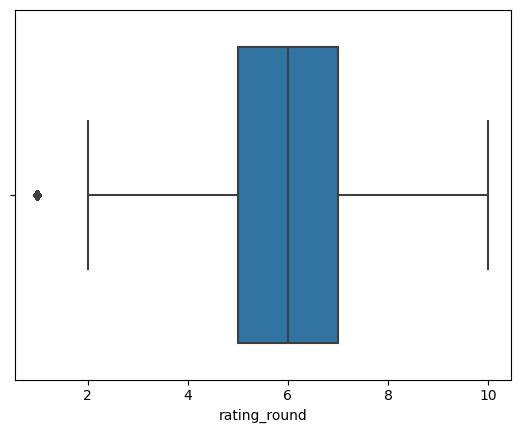

In [37]:
sns.boxplot(x=movie['rating_round'],data=movie)

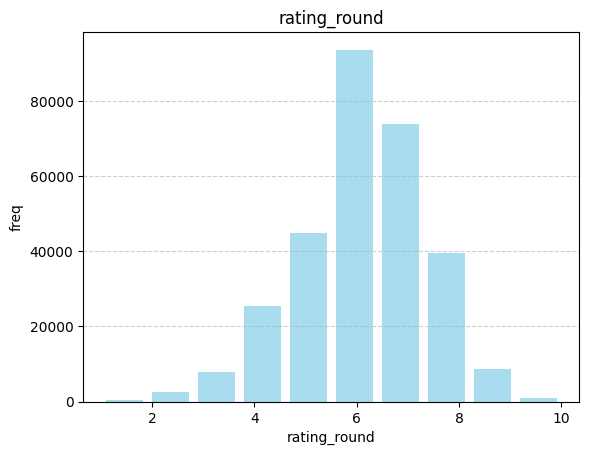

In [38]:
plt.hist(movie['rating_round'], bins=10, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('rating_round')
plt.ylabel('freq')
plt.title('rating_round')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

**Numerical features**

**Number of votes**

* Check the distribution of votes number for most of samples



In [39]:
num_fea=[]
num_fea.append('numVotes')

In [40]:
movie['numVotes'].describe()

count    2.974820e+05
mean     3.619521e+03
std      3.564735e+04
min      5.000000e+00
25%      1.900000e+01
50%      6.100000e+01
75%      3.130000e+02
max      2.802165e+06
Name: numVotes, dtype: float64

<Axes: xlabel='numVotes'>

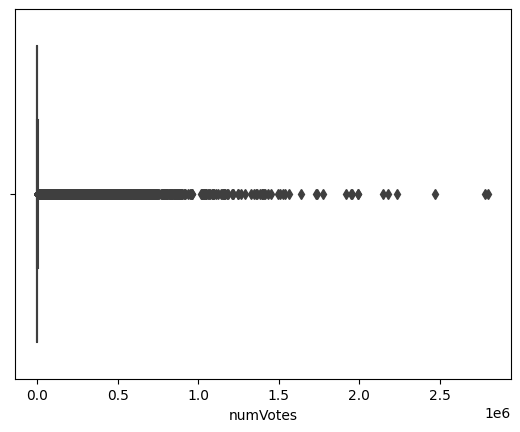

In [41]:
sns.boxplot(x=movie['numVotes'],data=movie)

A few movies have extremely high votes number

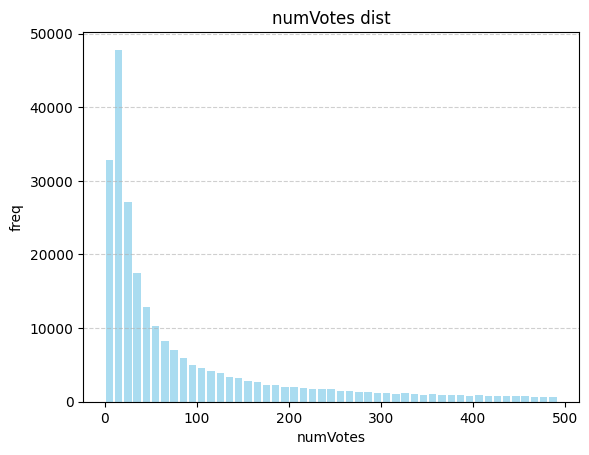

In [42]:
plt.hist(movie['numVotes'], bins=np.linspace(0,np.quantile(movie['numVotes'], 0.8) , num=50 ), rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('numVotes')
plt.ylabel('freq')
plt.title('numVotes dist')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

It seems that a lot of movies receive inadequate vote. For this part of movies, the result of average rating raise robustness issue, very likely to contain noise and undermine model performance. Thus, we should remove the movie such that numVote<50 from the sample.

In [43]:
sample=sample[sample.numVotes>=50]
print(len(sample))

160467


**Years released**

In [44]:
current_timestamp = datetime.now()
current_year = current_timestamp.year
print(f"Current Year: {current_year}")
movie.dropna(subset='startYear',inplace=True)
movie['startYear']=movie['startYear'].apply(int)
movie['years_released']=current_year-movie['startYear']

Current Year: 2023


In [45]:
movie['years_released'].describe()

count    297482.000000
mean         28.052534
std          25.842865
min           0.000000
25%           8.000000
50%          18.000000
75%          44.000000
max         129.000000
Name: years_released, dtype: float64

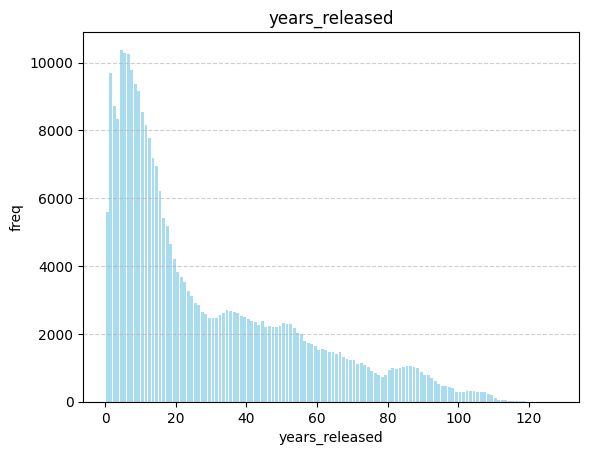

In [46]:
plt.hist(movie['years_released'], bins=np.arange(movie['years_released'].min(), movie['years_released'].max()) , rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('years_released')
plt.ylabel('freq')
plt.title('years_released')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

The distribuion of years of release is quite long tail, which would add difficulties for model to capture pattern. Moreover, as we discussed before,since IMDb is founded in 1990s, the average rating of movies that is produced long time ago is very likely to be biased. The main age group of internet users are often in their 20s/30s, so here we remove the movies produced 1970 from the sample.

* As we discussed before, we only consider movies produced after 1970 in the sample.

In [47]:
#remove sample with NAN value in start year
sample.dropna(subset=['startYear'],inplace=True)
sample['startYear']=sample['startYear'].apply(lambda x:int(x))
#remove movies produced after 1970
sample['years_released']=current_year-sample['startYear']
sample=sample[sample.startYear>=1970]
print(len(sample))

133739


In [48]:
sample['years_released'].isnull().sum()

0

In [49]:
num_fea.append('years_released')

**Duration**

As we detected before, there exist NANs in the runtimeMinutes column.Before we check its distribution, we should remove NANs.

In [50]:
duration=movie['runtimeMinutes'].dropna().apply(int)
duration.describe()

count    268173.000000
mean         94.441115
std         138.275947
min           1.000000
25%          81.000000
50%          91.000000
75%         103.000000
max       51420.000000
Name: runtimeMinutes, dtype: float64

<Axes: xlabel='runtimeMinutes'>

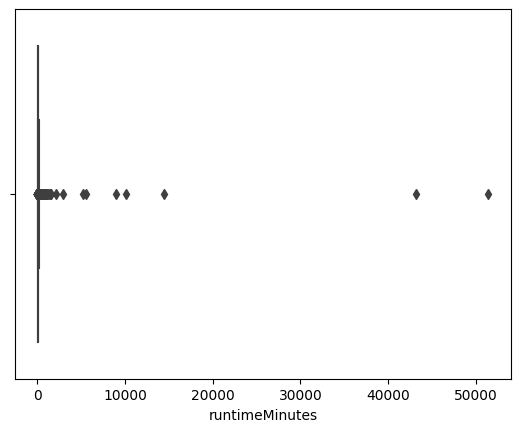

In [51]:
sns.boxplot(x=duration,data=movie)

In [52]:
np.quantile(duration, 0.995)

185.0

Only a few movies attain very long duration. Some movies have extremely high runtime minues, and we should remove those outliers.

In [53]:
durations=[i for i in duration if i<=200]

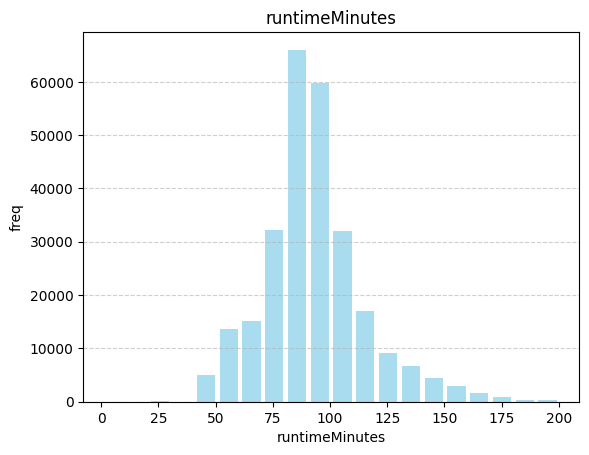

In [54]:
plt.hist(durations,bins=20, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('runtimeMinutes')
plt.ylabel('freq')
plt.title('runtimeMinutes')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

* Fill NANs in the runtimeMinutes column with sample mean:

In [55]:
sample['runtimeMinutes']=sample['runtimeMinutes'].apply(lambda x:int(x) if isinstance(x,str) else np.nan)
sample['runtimeMinutes'].fillna(np.mean(durations),inplace=True)

In [56]:
sample=sample[sample['runtimeMinutes']<200]
print(len(sample))

133405


In [57]:
num_fea.append('runtimeMinutes')

**Number of unique profession within production team**

In [58]:
movie[prof_fea].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297482 entries, 0 to 297518
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   actor_prof_cnt     297482 non-null  int64
 1   actress_prof_cnt   297482 non-null  int64
 2   composer_prof_cnt  297482 non-null  int64
 3   director_prof_cnt  297482 non-null  int64
 4   writer_prof_cnt    297482 non-null  int64
 5   editor_prof_cnt    297482 non-null  int64
dtypes: int64(6)
memory usage: 15.9 MB


In [59]:
movie[prof_fea].describe()

,actor_prof_cnt,actress_prof_cnt,composer_prof_cnt,director_prof_cnt,writer_prof_cnt,editor_prof_cnt
count,297482.000000,297482.000000,297482.000000,297482.000000,297482.000000,297482.000000
mean,1.934423,1.579205,1.899476,2.746170,1.566636,1.704664
std,0.919461,0.808831,0.945036,0.614613,0.855687,0.891971
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000
75%,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


It's better to treat them as categorical features since those features only contain 3 unique values. Let's save them for later.

**Number of genre included**

This feature means how many genres a movie entails from title_basic data.

In [60]:
movie.genre_cnt.describe()

count    297482.000000
mean          1.715579
std           0.890745
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: genre_cnt, dtype: float64

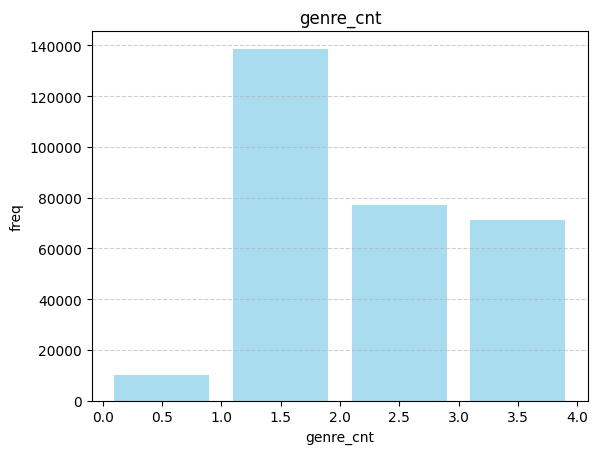

In [61]:
plt.hist(movie.genre_cnt,bins=4, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('genre_cnt')
plt.ylabel('freq')
plt.title('genre_cnt')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

For the movie that has NAN value in genre_cnt, we should fill na with 1 since a movie at least has one genre. Also, we should replace 0 with 1 in this column.

In [62]:
sample['genre_cnt'].fillna(1,inplace=True)
sample.replace({'genre_cnt': {0: 1}},inplace=True)

In [63]:
sample['genre_cnt'].describe()

count    133405.000000
mean          1.931599
std           0.847547
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: genre_cnt, dtype: float64

In [64]:
num_fea.append('genre_cnt')

**Numbe of how many versions of region a movie has**

This feature is from aka data basic. From the description of IMDb: "region (string) - the region for this version of the title". The assumption here is: the popular movie is more likely to be exported, and there therefore they would have more different 'aka' names in different regions.

In [65]:
aka.replace('\\N', np.nan,inplace=True)

In [66]:
aka_region=aka[['titleId','region']]
aka_region.dropna(inplace=True)
aka_region.drop_duplicates(inplace=True)
movie_region=aka_region.groupby(['titleId'])['region'].count().reset_index()
movie_region.columns=['titleId','region_cnt']
sample=sample.merge(movie_region, left_on='tconst', right_on='titleId',how='left')

<ipython-input-66-6e21ffcc8329>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aka_region.dropna(inplace=True)
<ipython-input-66-6e21ffcc8329>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aka_region.drop_duplicates(inplace=True)


In [67]:
print(len(sample))

133405


In [68]:
sample.region_cnt.describe()

count    133130.000000
mean          8.568797
std           9.885958
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         104.000000
Name: region_cnt, dtype: float64

<Axes: xlabel='region_cnt'>

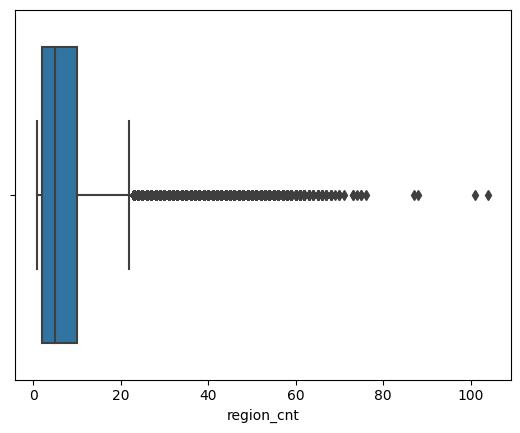

In [69]:
sns.boxplot(x=sample.region_cnt,data=sample)

Most of movies have versions of regions less than 30. To operate cautiously, we should do spot check for movies with extremely high versions of region.

In [71]:
sample[sample.region_cnt>100]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,...,actress_prof_cnt,composer_prof_cnt,director_prof_cnt,writer_prof_cnt,editor_prof_cnt,team_prof_cnt,featured,years_released,titleId,region_cnt
60520,tt1067106,movie,A Christmas Carol,A Christmas Carol,0,2009,NaN,96.0,"Adventure,Animation,Comedy",6.8,...,1,3,3,1,3,NaN,1,14,tt1067106,101.0
100047,tt2872750,movie,Shaun the Sheep Movie,Shaun the Sheep Movie,0,2015,NaN,85.0,"Adventure,Animation,Comedy",7.3,...,1,3,3,1,3,NaN,1,8,tt2872750,104.0


In [72]:
movie_high_region_cnt=aka[aka.titleId=='tt2872750']
print(len(movie_high_region_cnt))
movie_high_region_cnt.head()

150


,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
26289610,tt2872750,100,La Oveja Shaun: La Pelicula,XWW,es,imdbDisplay,NaN,0
26289611,tt2872750,101,Shaun the Sheep Movie,EG,en,imdbDisplay,NaN,0
26289612,tt2872750,102,Shaun y Ddafad: Y Ffilm,GB,cy,imdbDisplay,NaN,0
26289613,tt2872750,103,Shaun le Mouton: Le Film,CM,fr,imdbDisplay,NaN,0
26289614,tt2872750,104,Shaun el cordero,PE,NaN,imdbDisplay,NaN,0


Looks good!

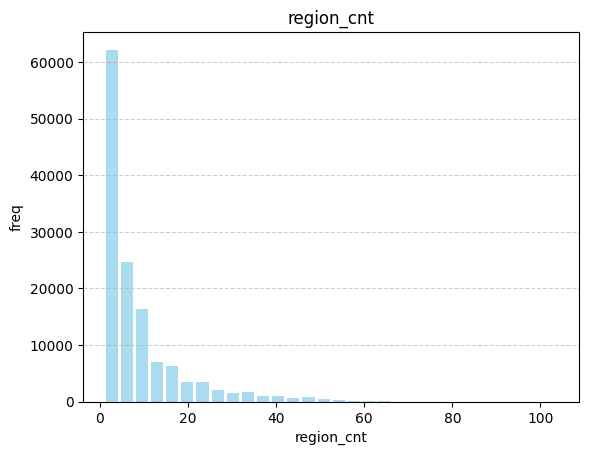

In [73]:
plt.hist(sample.region_cnt,bins=30, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('region_cnt')
plt.ylabel('freq')
plt.title('region_cnt')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Similarly, we should fillna in the region_cnt column with 1.

In [74]:
sample['region_cnt'].fillna(1,inplace=True)
sample.replace({'region_cnt': {0: 1}},inplace=True)

In [75]:
sample['region_cnt'].describe()

count    133405.000000
mean          8.553195
std           9.881728
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         104.000000
Name: region_cnt, dtype: float64

In [76]:
num_fea.append('region_cnt')

**Number of different language a movie's title attains in aka**

In [77]:
aka_lan=aka[['titleId','language']]
aka_lan.dropna(inplace=True)
aka_lan.drop_duplicates(inplace=True)
movie_lan=aka_lan.groupby(['titleId'])['language'].count().reset_index()
movie_lan.columns=['titleId','language_cnt']

<ipython-input-77-9e6b59fcff21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aka_lan.dropna(inplace=True)
<ipython-input-77-9e6b59fcff21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aka_lan.drop_duplicates(inplace=True)


In [78]:
movie_lan=aka_lan.groupby(['titleId'])['language'].count().reset_index()
movie_lan.columns=['titleId','language_cnt']

In [79]:
sample=sample.merge(movie_lan, left_on='tconst', right_on='titleId',how='left')

In [80]:
sample.language_cnt.isnull().sum()

40956

In [81]:
sample.language_cnt.describe()

count    92449.000000
mean         2.527761
std          1.996760
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         39.000000
Name: language_cnt, dtype: float64

There exist 2000+ written language in the world, so the max value here looks safe.

<Axes: xlabel='language_cnt'>

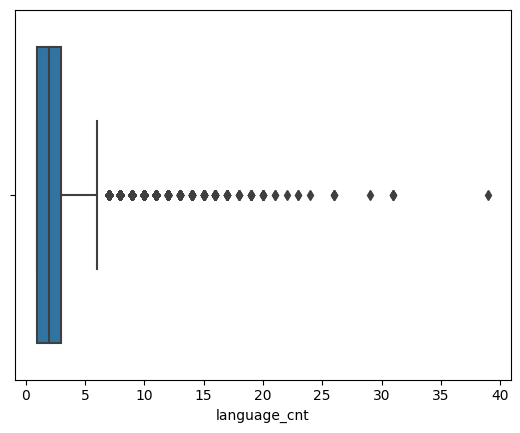

In [82]:
sns.boxplot(x=sample.language_cnt,data=sample)

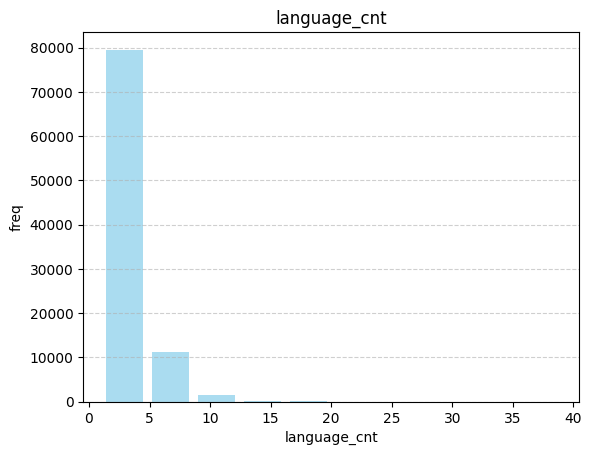

In [83]:
plt.hist(sample.language_cnt,bins=10, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('language_cnt')
plt.ylabel('freq')
plt.title('language_cnt')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [84]:
sample[sample.language_cnt>30]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,...,director_prof_cnt,writer_prof_cnt,editor_prof_cnt,team_prof_cnt,featured,years_released,titleId_x,region_cnt,titleId_y,language_cnt
47138,tt0407304,movie,War of the Worlds,War of the Worlds,0,2005,NaN,116.0,"Action,Adventure,Sci-Fi",6.5,...,3,1,2,NaN,1,18,tt0407304,70.0,tt0407304,31.0
60520,tt1067106,movie,A Christmas Carol,A Christmas Carol,0,2009,NaN,96.0,"Adventure,Animation,Comedy",6.8,...,3,1,3,NaN,1,14,tt1067106,101.0,tt1067106,31.0
95982,tt2418644,movie,Testing Movie1,Testing Movie1,0,2015,NaN,156.0,"Adventure,Animation,Family",7.3,...,3,1,3,NaN,1,8,tt2418644,48.0,tt2418644,39.0
100047,tt2872750,movie,Shaun the Sheep Movie,Shaun the Sheep Movie,0,2015,NaN,85.0,"Adventure,Animation,Comedy",7.3,...,3,1,3,NaN,1,8,tt2872750,104.0,tt2872750,31.0


Let's do some random spot check for《Testing Movie1》

In [85]:
language_max_cnt=aka[aka.titleId=='tt2418644']
print(len(set(language_max_cnt.language)))
print(set(language_max_cnt.language))

40
{'hy', 'de', 'te', 'haw', 'yi', 'fr', 'ko', 'qbn', 'th', 'tr', 'ca', 'tg', 'vi', 'en', 'kk', 'es', 'hr', 'ne', 'sd', 'gu', 'el', 'be', nan, 'ka', 'ta', 'ur', 'bg', 'ar', 'lb', 'nl', 'am', 'ku', 'mn', 'he', 'zh', 'fa', 'my', 'qac', 'ps', 'lo'}


Looks good!

* Similarly, fillna with 1 since a movie at least has one language version.

In [86]:
num_fea.append('language_cnt')

In [87]:
sample['language_cnt'].fillna(1,inplace=True)
sample['language_cnt'].isnull().sum()

0

* Note that we have removed some outliers in the sample. Once again, let's check the distribution of ratings.

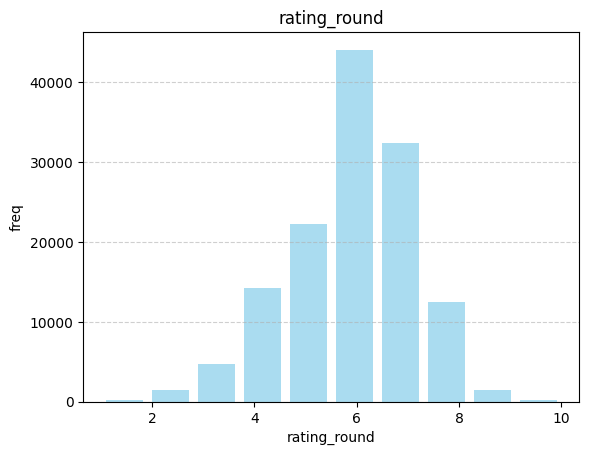

In [88]:
sample['rating_round']=sample['averageRating'].apply(round)
plt.hist(sample['rating_round'], bins=10, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('rating_round')
plt.ylabel('freq')
plt.title('rating_round')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Similar.

**Budget**

In [89]:
movie['budget'].isnull().sum()

150305

In [90]:
len(movie)

297482

In [91]:
budgets=movie['budget'].dropna().apply(float)

<Axes: xlabel='budget'>

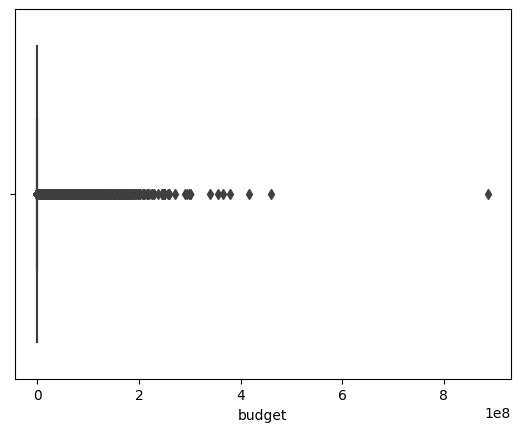

In [92]:
sns.boxplot(x=budgets,data=movie)

In [93]:
np.quantile(budgets, 0.9)

130000.0

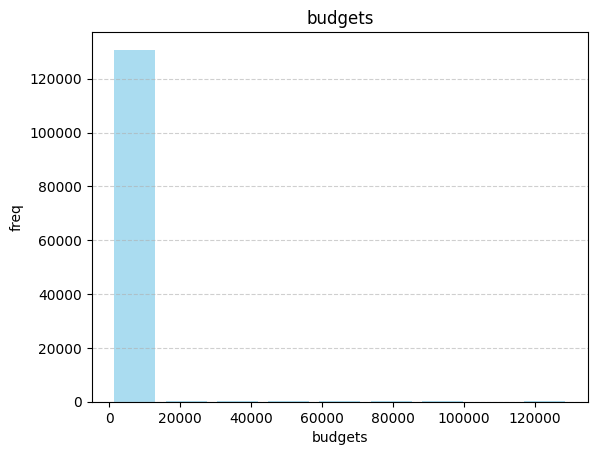

In [94]:
plt.hist(budgets,bins=np.linspace(budgets.min(), np.quantile(budgets, 0.9),num=10), rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('budgets')
plt.ylabel('freq')
plt.title('budgets')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [95]:
sample['budget'].isnull().sum()

5832

According to our assumptions, budget has great impact on movie quality and thus affect rating.Here we should remove sample with NANs in budget.

In [96]:
sample.dropna(subset=['budget'],inplace=True)

In [97]:
sample['budget'].isnull().sum()

0

In [98]:
sample['budget']=sample['budget'].apply(float)
num_fea.append('budget')
print(num_fea)

['numVotes', 'years_released', 'runtimeMinutes', 'genre_cnt', 'region_cnt', 'language_cnt', 'budget']


**Categorical Features**

**Genre**

We've made hypothesis that average movie rating under different genre would vary, so we should detect the average rating distribution among different genres. On the other hand, different of genre combinations may also have impact on rating.

Create one-hot variables for each genre

In [99]:
movie['genres'].fillna(movie['genres'].mode(),inplace=True)

In [100]:
movie['genres'].isnull().sum()

10180

In [101]:
movie.genres

0                            Romance
1             Documentary,News,Sport
2                                NaN
3         Action,Adventure,Biography
4                              Drama
                     ...            
297514                      Thriller
297515                 Drama,History
297516         Adventure,History,War
297517                         Drama
297518                         Drama
Name: genres, Length: 297482, dtype: object

* We can use Point-Biserial Correlation to compute correlation between rating and one-hot genre features.

In [102]:
def corr_binary(binary,rating):
    point_biserial_corr, _ = stats.pointbiserialr(binary, rating)
    return point_biserial_corr

In [103]:
#genre type
rat_by_genre=[]
cnt_by_genre=[]
corr_by_genre=[]
for i in genre_type:
  temp=movie[movie[i]==1]
  rat_by_genre.append(temp['averageRating'].mean())
  cnt_by_genre.append(len(temp))
  corr_by_genre.append(corr_binary(movie[i],movie['averageRating']))

average_rat=sample.averageRating.mean()
by_genre=pd.DataFrame({'genre':genre_type,'rating_avg':rat_by_genre,'cnt':cnt_by_genre,'corr':corr_by_genre})
by_genre['diff']=by_genre['rating_avg']-average_rat
by_genre['diff_abs']=by_genre['diff'].apply(abs)
by_genre['corr_abs']=by_genre['corr'].apply(abs)
by_genre.sort_values(by='corr_abs',ascending=False, inplace=True)
by_genre.head(10)

,genre,rating_avg,cnt,corr,diff,diff_abs,corr_abs
1,Documentary,7.232395,46170,0.330827,1.325977,1.325977,0.330827
18,Horror,4.999184,21577,-0.240438,-0.907234,0.907234,0.240438
15,Thriller,5.605443,24933,-0.126076,-0.300976,0.300976,0.126076
4,Action,5.725674,30802,-0.111811,-0.180745,0.180745,0.111811
9,Comedy,5.910553,73006,-0.110590,0.004134,0.004134,0.110590
6,Biography,6.961210,9242,0.102730,1.054791,1.054791,0.102730
14,Sci-Fi,5.329798,7014,-0.096069,-0.576621,0.576621,0.096069
13,History,6.811346,8294,0.078616,0.904927,0.904927,0.078616
5,Adventure,5.868653,18480,-0.057787,-0.037766,0.037766,0.057787
23,Adult,5.556907,4365,-0.055195,-0.349511,0.349511,0.055195


* Looks like documentary, horror genres will have impact on average rating, and this way we could reduce feature dimension generated from genre. Here we use 0.1 as threshold to select important one-hot genre features for future analysis.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'Documentary'),
  Text(1, 0, 'Horror'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Comedy'),
  Text(5, 0, 'Biography'),
  Text(6, 0, 'Sci-Fi'),
  Text(7, 0, 'History'),
  Text(8, 0, 'Adventure'),
  Text(9, 0, 'Adult'),
  Text(10, 0, 'Music'),
  Text(11, 0, 'Drama'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Crime'),
  Text(14, 0, 'Sport'),
  Text(15, 0, 'Fantasy'),
  Text(16, 0, 'News'),
  Text(17, 0, 'Western'),
  Text(18, 0, 'War'),
  Text(19, 0, 'Romance'),
  Text(20, 0, 'Animation'),
  Text(21, 0, 'Film-Noir'),
  Text(22, 0, 'Family'),
  Text(23, 0, 'Reality-TV'),
  Text(24, 0, 'Talk-Show'),
  Text(25, 0, 'Musical')])

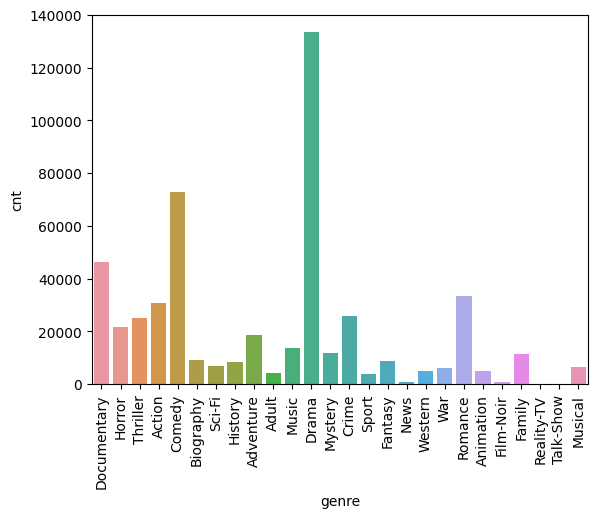

In [138]:
sns.barplot(x=by_genre.genre,y=by_genre.cnt)
plt.xticks(rotation=90)
plt.show()

In [104]:
genre_fea=by_genre[(by_genre.corr_abs>0.1)].genre.tolist()
genre_fea

['Documentary', 'Horror', 'Thriller', 'Action', 'Comedy', 'Biography']

For the table above, we can tell the frequency of those genres are not minor.

In [105]:
#use onehot_fea to store onehot features
onehot_fea=[]
onehot_fea=onehot_fea+genre_fea

**Genre combinations**

In [167]:
Counter(movie['genres'])

Counter({'Romance': 2784,
         'Documentary,News,Sport': 10,
         nan: 10180,
         'Action,Adventure,Biography': 62,
         'Drama': 50369,
         'Adventure,Fantasy': 200,
         'Comedy': 24486,
         'Drama,War': 2045,
         'Crime': 1509,
         'Drama,Romance': 9156,
         'Adventure,Drama': 977,
         'Biography,Drama,Family': 79,
         'Drama,History': 1139,
         'War': 507,
         'Biography,Drama,History': 814,
         'Sci-Fi': 863,
         'Adventure,Drama,Fantasy': 178,
         'Biography,Drama': 957,
         'Documentary,War': 409,
         'Biography,Drama,Romance': 215,
         'History,War': 40,
         'Action,Drama,Thriller': 853,
         'Crime,Thriller': 847,
         'Adventure': 1699,
         'Drama,Thriller': 3110,
         'Western': 2128,
         'Crime,Drama': 3853,
         'Documentary': 30985,
         'Comedy,Fantasy': 535,
         'Adventure,Drama,Romance': 449,
         'Crime,Drama,Mystery': 1307,
     

As we detected, movies could have many genres, and there exist too many combinations of genres.

In [143]:
genre_comb=movie.groupby('genres')['averageRating'].agg(['mean', 'count']).reset_index().sort_values(by=['mean'],ascending=False)
genre_comb.columns=['genres','avg_rating','cnt']
genre_comb['rating_diff']=genre_comb['avg_rating']-average_rat
genre_comb['diff_abs']=genre_comb['rating_diff'].apply(abs)
genre_comb[genre_comb.cnt>10].head(10)

,genres,avg_rating,cnt,rating_diff,diff_abs
911,"Documentary,Music,War",7.990909,11,2.084491,2.084491
867,"Documentary,Family,Music",7.951724,29,2.045306,2.045306
873,"Documentary,Family,Sport",7.889474,19,1.983055,1.983055
431,"Animation,Biography,Comedy",7.663636,11,1.757218,1.757218
572,"Biography,Documentary,War",7.645161,31,1.738743,1.738743
332,"Adventure,Documentary,Music",7.643750,16,1.737332,1.737332
564,"Biography,Documentary,Musical",7.620000,15,1.713582,1.713582
1195,Music,7.560595,538,1.654177,1.654177
338,"Adventure,Documentary,Sport",7.556338,71,1.649920,1.649920
101,"Action,Documentary,Sport",7.541026,39,1.634607,1.634607


* Check correlation between genre combination and rating:

In [107]:
def cramer_corr(x,y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    print(f"Cramer's V: {cramer_v:.4f}")
    return cramer_v

In [108]:
cramer_corr(movie['genres'], movie['rating_round'])

Cramer's V: 0.1918


0.19176527546677494

* Not very strong, but consdering our previous assumptions, let's keep it first

In [109]:
cat_fea=[]
cat_fea.append('genres')

**Era**

We have removed movies produced before 1970 from the sample. We can divide 1970-2023 with 10-year interval and create categorical features.

In [110]:
def get_era(x):
  if x <=10:
    return '1970s'
  elif x<=20:
    return '1980s'
  elif x<=30:
    return '1990s'
  elif x<40:
    return '2000s'
  else:
    return '2010s'
#here we label movie produced after 2020 with 2010s
sample['era']=sample['years_released'].apply(get_era)

* Check correlation between era and rating

In [111]:
cramer_corr(sample['era'], sample['rating_round'])

Cramer's V: 0.0458


0.04578936405290308

* Check movie's distribution in each era:

In [112]:
by_era=sample.groupby('era')['averageRating'].agg(['mean', 'count']).reset_index().sort_values(by=['mean'],ascending=False)
by_era.columns=['era','avg_rating','cnt']
by_era['rating_diff']=by_era['avg_rating']-average_rat
by_era['diff_abs']=by_era['rating_diff'].apply(abs)


In [113]:
by_era

,era,avg_rating,cnt,rating_diff,diff_abs
4,2010s,6.047226,14545,0.140808,0.140808
3,2000s,5.964195,11638,0.057777,0.057777
2,1990s,5.916492,16614,0.010074,0.010074
1,1980s,5.896999,32226,-0.009419,0.009419
0,1970s,5.857241,52550,-0.049178,0.049178


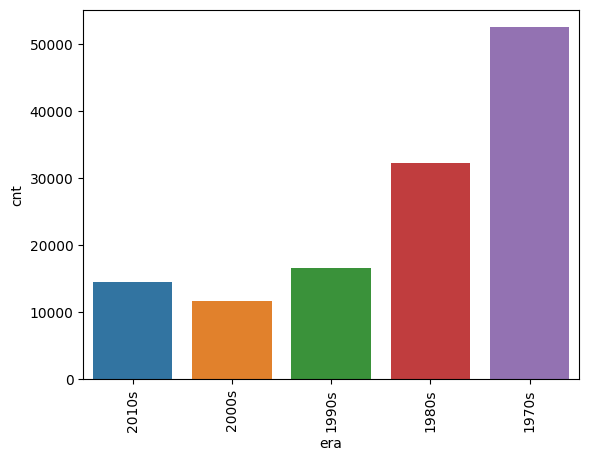

In [145]:
sns.barplot(x=by_era.era,y=by_era.cnt)
plt.xticks(rotation=90)
plt.show()

The average rating of movies is creasing slightly by time.

Even though the correlation is not strong, but one of our basic assumptions is that produced era would have impacts on movie rating.

Let's keep them.

In [114]:
cat_fea.append('era')

**Interaction Feature: Era & Genre**

One of our assumptions is that the trending genre of different eras is different. We could create interation features to see if there exist impacts.
* First we need create one-hot vaiables for different era
* Then we could create interaction features by multipling era features and genre features.
* Doing this would greatly increase feature dimension. Among those interaction features, we should onyl select features with high correlation.
* The insight of this feature is like: "the movie's genre is drama and the movie is produced in 1970s"


In [115]:
era_fea=list(set(by_era.era))
for era in era_fea:
  sample[era]=sample['era'].apply(lambda x:1 if x==era else 0)

In [116]:
onehot_fea=onehot_fea+era_fea

In [117]:
era_genra_fea=[]
for i in genre_type:
  for j in era_fea:
    era_genra_fea.append(i+'_'+j)
    sample[i+'_'+j]=sample[i]*sample[j]

<ipython-input-117-2d76e7c75ec7>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample[i+'_'+j]=sample[i]*sample[j]
<ipython-input-117-2d76e7c75ec7>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample[i+'_'+j]=sample[i]*sample[j]
<ipython-input-117-2d76e7c75ec7>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [118]:
diff_genre_era=[]
cnt_genre_era=[]
corr_genre_ear=[]
for i in era_genra_fea:
  temp1=sample[sample[i]==1]
  cnt_genre_era.append(len(temp1))
  diff=temp1.averageRating.mean()-average_rat
  diff_genre_era.append(diff)
  corr_genre_ear.append(corr_binary(sample[i],sample['averageRating']))

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [119]:
by_era_gnere=pd.DataFrame({'era_genre':era_genra_fea,'rating_diff':diff_genre_era,'cnt':cnt_genre_era,'corr':corr_genre_ear})
by_era_gnere['rating_diff_abs']=by_era_gnere['rating_diff'].apply(abs)
by_era_gnere['corr_abs']=by_era_gnere['corr'].apply(abs)
by_era_gnere.sort_values(by='corr_abs',ascending=False,inplace=True)
by_era_gnere[(by_era_gnere.rating_diff_abs>0.5)].head(10)

,era_genre,rating_diff,cnt,corr,rating_diff_abs,corr_abs
91,Horror_1970s,-1.372885,6665,-0.246849,1.372885,0.246849
6,Documentary_1970s,1.143668,8068,0.227570,1.143668,0.227570
9,Documentary_1980s,1.233290,4460,0.179765,1.233290,0.179765
94,Horror_1980s,-1.286761,3439,-0.164019,1.286761,0.164019
76,Thriller_1970s,-0.684346,7788,-0.133632,0.684346,0.133632
31,Biography_1970s,0.923546,2553,0.101069,0.923546,0.101069
71,Sci-Fi_1970s,-1.003372,1871,-0.093746,1.003372,0.093746
7,Documentary_1990s,1.208462,1129,0.087449,1.208462,0.087449
79,Thriller_1980s,-0.634990,3696,-0.083997,0.634990,0.083997
92,Horror_1990s,-1.003426,1036,-0.069531,1.003426,0.069531


* There are some surprising finding on trending genre by era here. Considering the impact of those features on rating and sample size, and feature dimension, we consider interaction feature with topic correlations.
* In the feature selection sec, we will check correlation between interaction feature and raw features.

In [120]:
interaction_fea=by_era_gnere[by_era_gnere.corr_abs>0.1].era_genre.tolist()

In [121]:
interaction_fea

['Horror_1970s',
 'Documentary_1970s',
 'Documentary_1980s',
 'Horror_1980s',
 'Thriller_1970s',
 'Biography_1970s']

In [122]:
onehot_fea=onehot_fea+interaction_fea

interation features here are possibly co-related with genre features, remeber to check in the feature selection section.

**Production Team**

In [123]:
sample[pri_fea].isnull().sum()

actor       13957
actress     25278
composer    41930
director     7216
writer      77389
editor      49174
dtype: int64

* Each feature is the name is of a productin member
* This feature is categorical and contain multiple classes.

Check distribution of labels for each feature:




In [174]:
pri_fea_cnt=[]
for i in pri_fea:
  cnt=len(dict(Counter(movie[i])).keys())
  pri_fea_cnt.append(cnt)
  print(i,'has',cnt,'categories')


actor has 112134 categories
actress has 97680 categories
composer has 57371 categories
director has 107204 categories
writer has 40944 categories
editor has 85754 categories


Correlation analysis

In [124]:
for i in pri_fea:
  print(i,cramer_corr(sample[i],sample['rating_round']))
  print((i),len(set(sample[i])))

Cramer's V: 0.7877
actor 0.7877278301432344
actor 52415
Cramer's V: 0.7898
actress 0.789766702915474
actress 47471
Cramer's V: 0.7010
composer 0.700956608843482
composer 30822
Cramer's V: 0.7731
director 0.7730565543059015
director 53329
Cramer's V: 0.7604
writer 0.7604355244239612
writer 21073
Cramer's V: 0.8412
editor 0.8412012635772487
editor 46556


* Accords with our assumption, core members is highly correlated with movie rating. For the missing values, we regrad them as a single categorical label.

Highly correlated with rating! Should be included in the model.

In [125]:
cat_fea=cat_fea+pri_fea
print(cat_fea)

['genres', 'era', 'actor', 'actress', 'composer', 'director', 'writer', 'editor']


**Profession cnt of production team**

In [129]:
cramer_corr(movie['genres'], movie['rating_round'])

Cramer's V: 0.1918


0.19176527546677494

In [130]:
for i in movie[prof_fea]:
  print(i,cramer_corr(movie[i], movie['rating_round']))

Cramer's V: 0.1242
actor_prof_cnt 0.12418718238951092
Cramer's V: 0.1122
actress_prof_cnt 0.11224643687792787
Cramer's V: 0.0621
composer_prof_cnt 0.06210286084067693
Cramer's V: 0.0546
director_prof_cnt 0.054645208674614296
Cramer's V: 0.0321
writer_prof_cnt 0.032070378331184965
Cramer's V: 0.0928
editor_prof_cnt 0.09280972394303146


* They are potentially correlated to other production team feature and their correlation with rating is not strong. No need to include them in the model.

In [131]:
sample[num_fea+onehot_fea+cat_fea].isnull().sum()

numVotes                 0
years_released           0
runtimeMinutes           0
genre_cnt                0
region_cnt               0
language_cnt             0
budget                   0
Documentary              0
Horror                   0
Thriller                 0
Action                   0
Comedy                   0
Biography                0
2000s                    0
1970s                    0
1990s                    0
2010s                    0
1980s                    0
Horror_1970s             0
Documentary_1970s        0
Documentary_1980s        0
Horror_1980s             0
Thriller_1970s           0
Biography_1970s          0
genres                 314
era                      0
actor                13957
actress              25278
composer             41930
director              7216
writer               77389
editor               49174
dtype: int64

* Note there are missing values in categorical features. We can fill those NANs within categorical features with a new category "unkown."

In [132]:
for i in cat_fea:
  sample[i].fillna('unkown',inplace=True)

In [133]:
sample[num_fea+onehot_fea+cat_fea].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127573 entries, 0 to 133404
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   numVotes           127573 non-null  int64  
 1   years_released     127573 non-null  int64  
 2   runtimeMinutes     127573 non-null  float64
 3   genre_cnt          127573 non-null  int64  
 4   region_cnt         127573 non-null  float64
 5   language_cnt       127573 non-null  float64
 6   budget             127573 non-null  float64
 7   Documentary        127573 non-null  int64  
 8   Horror             127573 non-null  int64  
 9   Thriller           127573 non-null  int64  
 10  Action             127573 non-null  int64  
 11  Comedy             127573 non-null  int64  
 12  Biography          127573 non-null  int64  
 13  2000s              127573 non-null  int64  
 14  1970s              127573 non-null  int64  
 15  1990s              127573 non-null  int64  
 16  20

In [392]:
print(len(num_fea+onehot_fea+cat_fea+prof_fea))
y_var=['averageRating']
#sample[num_fea+onehot_fea+cat_fea+y_var+prof_fea].to_csv('/content/drive/MyDrive/IMDB/data.csv')

38


# **Feature Preprocessing & Selection**

In [175]:
sample=pd.read_csv('/content/drive/MyDrive/IMDB/data.csv')

* In the previous section we have created many features. We should reduced feature dimension and only keep important ones.
* We have 4 types of features:
    
    **Numerical features**

   **Binary class features that describe genre**

    **Multiclass features**

    **Era features**

In [176]:
num_fea=['numVotes', 'years_released', 'runtimeMinutes',
       'genre_cnt', 'region_cnt', 'language_cnt', 'budget']
bi_fea=[ 'Documentary', 'Horror', 'Thriller', 'Action', 'Comedy', 'Biography', 'Horror_1970s', 'Documentary_1970s',
       'Documentary_1980s', 'Horror_1980s', 'Thriller_1970s',
       'Biography_1970s']
era_fea=[ '2010s', '1970s',  '1980s', '2000s', '1990s',]
mul_fea=[  'genres','era', 'actor', 'actress', 'composer',
       'director', 'writer', 'editor']
y_var=['averageRating']

In [177]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127573 entries, 0 to 127572
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         127573 non-null  int64  
 1   numVotes           127573 non-null  int64  
 2   years_released     127573 non-null  int64  
 3   runtimeMinutes     127573 non-null  float64
 4   genre_cnt          127573 non-null  int64  
 5   region_cnt         127573 non-null  float64
 6   language_cnt       127573 non-null  float64
 7   budget             127573 non-null  float64
 8   Documentary        127573 non-null  int64  
 9   Horror             127573 non-null  int64  
 10  Thriller           127573 non-null  int64  
 11  Action             127573 non-null  int64  
 12  Comedy             127573 non-null  int64  
 13  Biography          127573 non-null  int64  
 14  2010s              127573 non-null  int64  
 15  1970s              127573 non-null  int64  
 16  19

* Let's first fill NANs for multi-class features with category 'unkown'.

In [178]:
for i in mul_fea:
  sample[i].fillna('unkown',inplace=True)

In [179]:
sample[mul_fea].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127573 entries, 0 to 127572
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   genres    127573 non-null  object
 1   era       127573 non-null  object
 2   actor     127573 non-null  object
 3   actress   127573 non-null  object
 4   composer  127573 non-null  object
 5   director  127573 non-null  object
 6   writer    127573 non-null  object
 7   editor    127573 non-null  object
dtypes: object(8)
memory usage: 7.8+ MB


* We need encode categorical feature. As our EDA shows, those categorical features, which related to movie genre and production team, contains many categories each. It's not realistic to do one-hot encoding, which would create too many features.
* As we assumed, mainstream aesthetic trending has an impact on movie rating, which could be revealed by frequency of movie genre under different era.
* Production team members are also assumed to have an impact on movie rating. Another assumption here is "a good and famous director is more likey to be selected by movie companies and thus make more movies". This assumption is the same for other production team members.
* Since the frequency of categories here is informative, we can encode each category with the count of its occurrences in the dataset.  

In [180]:
for fea in mul_fea:
    # Assuming 'Categorical_Column' is your categorical feature
  frequency_encoding = sample[fea].value_counts().to_dict()
  sample[fea] = sample[fea].map(frequency_encoding)


In [181]:
sample[mul_fea].head()

,genres,era,actor,actress,composer,director,writer,editor
0,8394,52550,13957,25278,41930,1,77389,49174
1,168,16614,22,28,42,12,6,5
2,614,14545,1,4,1,13,77389,1
3,127,14545,1,25278,41930,11,77389,1
4,18874,14545,18,7,2,16,48,3


In [182]:
sample[num_fea+mul_fea+bi_fea+era_fea].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127573 entries, 0 to 127572
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   numVotes           127573 non-null  int64  
 1   years_released     127573 non-null  int64  
 2   runtimeMinutes     127573 non-null  float64
 3   genre_cnt          127573 non-null  int64  
 4   region_cnt         127573 non-null  float64
 5   language_cnt       127573 non-null  float64
 6   budget             127573 non-null  float64
 7   genres             127573 non-null  int64  
 8   era                127573 non-null  int64  
 9   actor              127573 non-null  int64  
 10  actress            127573 non-null  int64  
 11  composer           127573 non-null  int64  
 12  director           127573 non-null  int64  
 13  writer             127573 non-null  int64  
 14  editor             127573 non-null  int64  
 15  Documentary        127573 non-null  int64  
 16  Ho

**Correlation Matrix**

<Axes: >

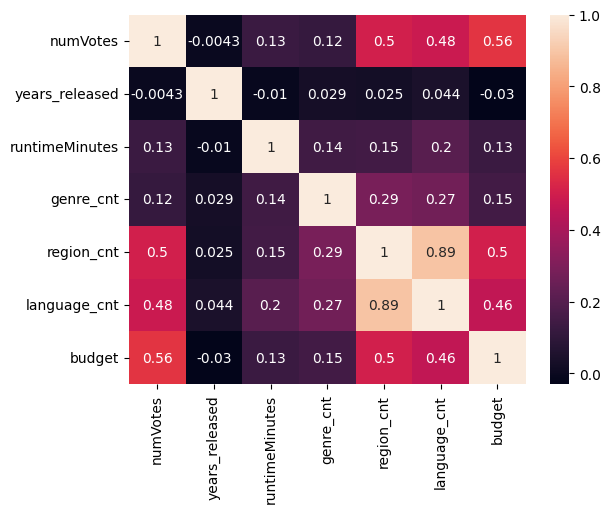

In [183]:
corr_matrix=sample[num_fea].corr()
sns.heatmap(corr_matrix,annot=True)

* region_cnt and language_cnt are both highly correlated with budget.
* Since budge is an essential feature under our assumption, we should think about removing region_cnt and numVotes.
* Besides correlation matrix, we should also look into multicolinearity.

**Multi colinearity**

In [184]:
vif_data = pd.DataFrame()
vif_data["Feature"] =num_fea
vif_data["VIF"] =[variance_inflation_factor(sample[num_fea].values, i) for i in range(sample[num_fea].shape[1])]
vif_data

,Feature,VIF
0,numVotes,1.665098
1,years_released,2.442396
2,runtimeMinutes,7.444599
3,genre_cnt,6.335436
4,region_cnt,9.407281
5,language_cnt,11.692123
6,budget,1.659984


* Language_cnt has high VIF, where we consider 10 to be a threshold.

* From the correlation and multicolinearity analysis, we should remove language_cnt, region_vnt, and numVotes.

In [185]:
num_fea.remove('language_cnt')
num_fea.remove('region_cnt')
num_fea.remove('numVotes')

In [186]:
sample[num_fea].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127573 entries, 0 to 127572
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   years_released  127573 non-null  int64  
 1   runtimeMinutes  127573 non-null  float64
 2   genre_cnt       127573 non-null  int64  
 3   budget          127573 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.9 MB


**Apply random forest to select categorical features**

* We have intuitively assumed era have impact on movie rating, so we should keep era-related feature and do feature selection for others.
* For other categorical features, we use random forest for keeping most important features.

In [187]:
# Train a Random Forest classifier
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(sample[bi_fea+mul_fea], sample[y_var])
# Get feature importances
feature_importances = rf.feature_importances_

<ipython-input-187-8bbbb01e8a4a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(sample[bi_fea+mul_fea], sample[y_var])


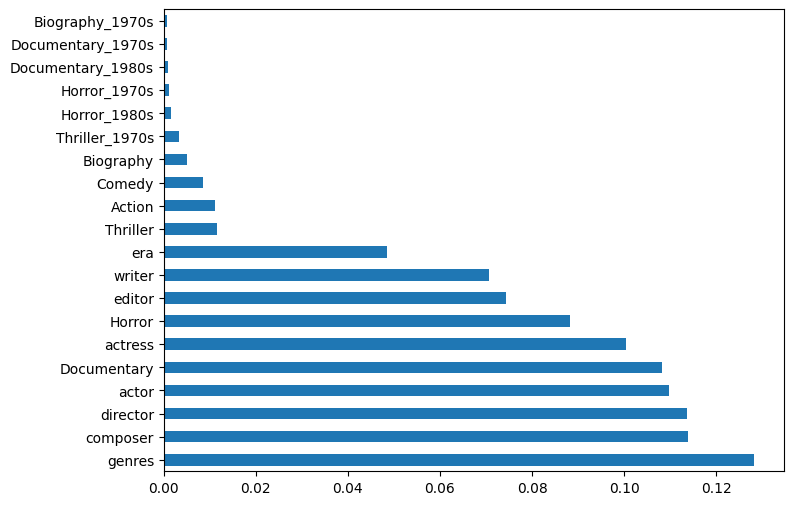

In [188]:
plt.figure(figsize = (8,6))
rf_importances = pd.Series(rf.feature_importances_, index=bi_fea+mul_fea)
rf_importances.nlargest(20).plot(kind='barh')
plt.show()

* Here the top 10 features are obviously more important than others.
* Store those features with cat_fea list

In [189]:
rf_importance=pd.DataFrame({"feature":bi_fea+mul_fea, 'importance':feature_importances})
rf_importance.sort_values(by='importance',ascending=False,inplace=True)
cat_fea=rf_importance.head(10)['feature'].tolist()
rf_importance.head(20)

,feature,importance
12,genres,0.128240
16,composer,0.113924
17,director,0.113617
14,actor,0.109678
0,Documentary,0.108239
15,actress,0.100337
1,Horror,0.088191
19,editor,0.074391
18,writer,0.070598
13,era,0.048576


**Apply Ridge regression to doubt check numerical feature**



* For L2 regularization, we need standarize numerical features

In [190]:
num_features = sample[num_fea]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(num_features)
scaled_num_features = pd.DataFrame(scaled_features, columns=(num_features.columns))
sample[num_fea]=scaled_num_features

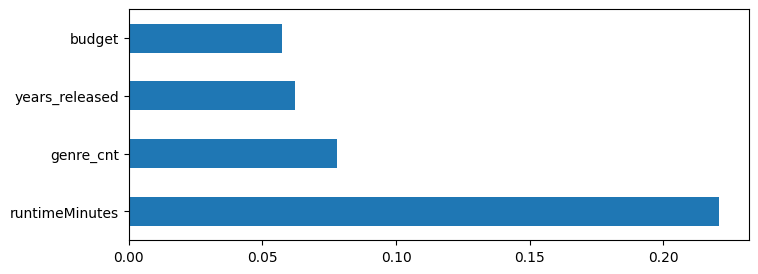

In [191]:
ridge=Ridge(alpha = 1.0)
ridge.fit(sample[num_fea], sample[y_var])
coef_abs = np.abs(ridge.coef_)
plt.figure(figsize = (8,3))
rf_importances = pd.Series(coef_abs[0], index=num_fea)
rf_importances.nlargest(20).plot(kind='barh')
plt.show()

* We have assumed that budget's impact to movie rating is great. Thus. for the features with higher importance than budget, we should include them in the model.

#**Model Training & Evaluation**

**Finalized fature set**

* we use num_fea to store numerical features, use era_fea to store time-related feature, cat_fea for other selected categorical features.

**Split Training and Test set**

In [192]:
X=sample[num_fea+era_fea+cat_fea]
y=sample[y_var]
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [193]:
print(len(X_train),len(X_test))

95679 31894


In [194]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127573 entries, 0 to 127572
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   years_released  127573 non-null  float64
 1   runtimeMinutes  127573 non-null  float64
 2   genre_cnt       127573 non-null  float64
 3   budget          127573 non-null  float64
 4   2010s           127573 non-null  int64  
 5   1970s           127573 non-null  int64  
 6   1980s           127573 non-null  int64  
 7   2000s           127573 non-null  int64  
 8   1990s           127573 non-null  int64  
 9   genres          127573 non-null  int64  
 10  composer        127573 non-null  int64  
 11  director        127573 non-null  int64  
 12  actor           127573 non-null  int64  
 13  Documentary     127573 non-null  int64  
 14  actress         127573 non-null  int64  
 15  Horror          127573 non-null  int64  
 16  editor          127573 non-null  int64  
 17  writer    

**Model Design**

* The target variable here is average moving rating, it's a continuous variable
* As EDA shows, the rounded average rating is not evenly distributed among 1~10, if we choose classification model, label balance would be a big issue.

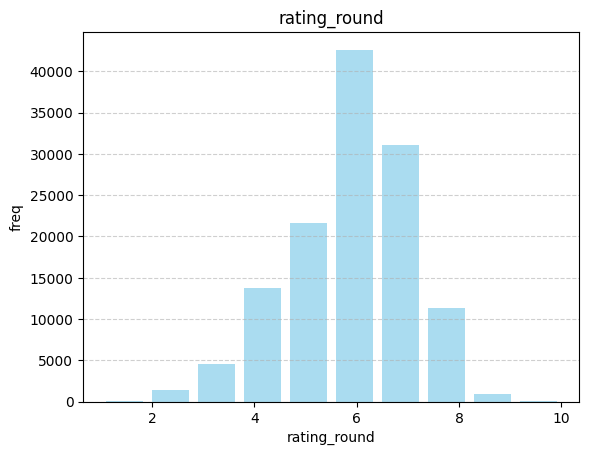

In [195]:
sample['rating_round']=sample['averageRating'].apply(round)
plt.hist(sample['rating_round'], bins=10, rwidth=0.8, alpha=0.7, color='skyblue')
plt.xlabel('rating_round')
plt.ylabel('freq')
plt.title('rating_round')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Therefore, we should use regression model for prediction.

**Evaluation Metrics**

* For regression modeling, we can use R2 score(**R^2**), mean squared error(**mse**), root mean squared error(**rmse**), mean absolute error(**mae**) for performance evaluation.
* Also, it's important to detect if there exiset **over fitting** in the model.

In [196]:
def eval(model):
    print('model evaluation')
    y_pred= model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(mse)
    mae=mean_absolute_error(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    print('-')
    print('Test set:')
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")

    y_pred_train=model.predict(X_train)
    mse_train= mean_squared_error(y_train, y_pred_train)
    rmse_train=np.sqrt(mse_train)
    mae_train=mean_absolute_error(y_train, y_pred_train)
    r2_train=r2_score(y_train, y_pred_train)
    print('-')
    print('Train set:')
    print(f"Mean Squared Error: {mse_train:.2f}")
    print(f"Root Mean Squared Error: {rmse_train:.2f}")
    print(f"Mean Absolute Error: {mae_train:.2f}")
    print(f"R2 Score: {r2_train:.2f}")
    return

**Model Traing & Selection**

* **Baseline: Linear Model**

In [222]:
LR = LinearRegression()
LR.fit(X_train[num_fea+era_fea], y_train)
y_pred = LR.predict(X_test[num_fea+era_fea])
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
print('Test set:')
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"mean_absolute_error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")
print('-')


print('Train set:')
y_pred_train=LR.predict(X_train[num_fea+era_fea])
mse_train= mean_squared_error(y_train, y_pred_train)
rmse_train=np.sqrt(mse_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
r2_train=r2_score(y_train, y_pred_train)
print('-')
print('Train set:')
print(f"Mean Squared Error: {mse_train:.2f}")
print(f"Root Mean Squared Error: {rmse_train:.2f}")
print(f"Mean Absolute Error: {mae_train:.2f}")
print(f"R2 Score: {r2_train:.2f}")

Test set:
Mean Squared Error: 1.63
Root Mean Squared Error: 1.28
mean_absolute_error: 1.02
R-squared: 0.04
-
Train set:
-
Train set:
Mean Squared Error: 1.65
Root Mean Squared Error: 1.28
Mean Absolute Error: 1.02
R2 Score: 0.03


Baseline model evaluation:

**Test set:**

* Mean Squared Error: 1.64

* Root Mean Squared Error: 1.28

* Mean Absolute Error: 1.02

* R2 Score: 0.034

**Train set:**

* Mean Squared Error: 1.65

* Root Mean Squared Error: 1.28

* Mean Absolute Error: 1.02

* R2 Score: 0.03


* It seems linear model didn't fit data very well, potentially it's because  linear model cannot take categorical features and non-linear patterns.
* Let's try ensemble models. They usually generate better prediction result, but **over fitting** is a potential issue. Also, we should try parameter tuning.

* **Random Forest**

In [199]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf = 5,random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
eval(rf_model)

<ipython-input-199-d3a6dfe28b25>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


-
Test set:
Mean Squared Error: 1.13
Root Mean Squared Error: 1.06
Mean Absolute Error: 0.82
R2 Score: 0.33
-
Train set:
Mean Squared Error: 0.88
Root Mean Squared Error: 0.94
Mean Absolute Error: 0.71
R2 Score: 0.48


* **LGBM**

In [200]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
          'n_estimators':200,
          'boosting_type': 'gbdt',
          'metric': 'mean_squared_error',
          'num_leaves': 20,
          'max_depth':10,
          'learning_rate': 0.1,
          'feature_fraction': 1,
          'bagging_fraction': 1
         }
num_round = 100  # Number of boosting rounds (you can adjust this)
lgbm = lgb.train(params, train_data, num_round, valid_sets=[test_data])
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)
eval(lgbm )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 95679, number of used features: 19


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 5.906733
-
Test set:
Mean Squared Error: 1.10
Root Mean Squared Error: 1.05
Mean Absolute Error: 0.81
R2 Score: 0.35
-
Train set:
Mean Squared Error: 1.05
Root Mean Squared Error: 1.03
Mean Absolute Error: 0.79
R2 Score: 0.38


* **XGBoost**

In [201]:
xgb_model = XGBRegressor(
              n_estimators=200,
              max_depth=10,
              learning_rate=0.1,
              random_state=42,
              reg_lambda=1,
              eta=0.1,
              gamma=0,
              min_child_weight=5 )

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

eval(xgb_model)

-
Test set:
Mean Squared Error: 1.08
Root Mean Squared Error: 1.04
Mean Absolute Error: 0.80
R2 Score: 0.37
-
Train set:
Mean Squared Error: 0.61
Root Mean Squared Error: 0.78
Mean Absolute Error: 0.58
R2 Score: 0.64


**Fine tuning**

After trying different models, it seems XGBoost would potentially be the best model considering model error and over fitting.（It has the best R^2 score on test set）

Here we choose randomized search for fine tunning since it's fast.

* **XGBoost Tuning**

In [211]:
param_xgb = {
    'n_estimators':randint(100, 200),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.05, 0.15),
    'subsample': uniform(0.7, 1.0),
    'min_child_weight': randint(1, 5),
    'reg_lambda':uniform(1, 2),
    'min_split_loss':uniform(0,1)
}

xgb_model = XGBRegressor(random_state=42)

random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_xgb,
    n_iter=100,
    cv=5,
    n_jobs=-1,  # Use all available CPU cores
    scoring='neg_mean_squared_error',
    random_state=42
)

# Perform Randomized Search
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_
best_xgb_params = random_search_xgb.best_params_
eval(best_xgb)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
355 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 620, in inner_f
 

-
Test set:
Mean Squared Error: 1.07
Root Mean Squared Error: 1.04
Mean Absolute Error: 0.80
R2 Score: 0.37
-
Train set:
Mean Squared Error: 0.89
Root Mean Squared Error: 0.94
Mean Absolute Error: 0.72
R2 Score: 0.48


Here is the performance of our best XGBoost model:

**Test set:**

* Mean Squared Error: 1.07

* Root Mean Squared Error: 1.04

* Mean Absolute Error: 0.80

* R2 Score: 0.37

**Train set:**

* Mean Squared Error: 0.89

* Root Mean Squared Error: 0.94

* Mean Absolute Error: 0.72

* R2 Score: 0.48

**Far exceed the baseline model!**

**Best parameter check**

In [216]:
print(random_search_xgb.best_params_)

{'learning_rate': 0.1334007557963877, 'max_depth': 7, 'min_child_weight': 4, 'min_split_loss': 0.5277011090862999, 'n_estimators': 174, 'reg_lambda': 2.838231430557319, 'subsample': 0.9529901679892411}


* With max_depth=7, min_child_weight=4, reg_lambda=2.8, the over fitting is much relieved.
 This can also be revealed from R^2 score on train & test set.

Unfortunately, given time and computational cost limitation, we just can't fulfill the full potential of ensemble models.

**Save the best model:**

In [213]:
model_path ='/content/drive/MyDrive/IMDB/'+str(current_timestamp.date())+"_best_xgb.model"
best_xgb.save_model(model_path)
#loaded_model = xgb.Booster(model_file=model_path)

# Conclusion & Summary

**Analysis of model result**


The best model built here is XGBoost, with feature set and metrics as below:

In [235]:
print(X_train.columns)

Index(['years_released', 'runtimeMinutes', 'genre_cnt', 'budget', '2010s',
       '1970s', '1980s', '2000s', '1990s', 'genres', 'composer', 'director',
       'actor', 'Documentary', 'actress', 'Horror', 'editor', 'writer', 'era'],
      dtype='object')


**Test set:**

Mean Squared Error: 1.07

Root Mean Squared Error: 1.04

Mean Absolute Error: 0.80

**R2 Score: 0.37**

Train set:

Mean Squared Error: 0.89

Root Mean Squared Error: 0.94

Mean Absolute Error: 0.72

R2 Score: 0.48

* **Residual distribution**



In [234]:
y_pred=best_xgb.predict(X_test)
test_data=X_test.copy()
test_data['pred']=y_pred
test_data['true']=y_test
test_data['res']=test_data['pred']-test_data['true']
test_data.groupby('era')['res'].agg(['mean','count'])

,mean,count
era,,
11638,0.001763,2878
14545,-0.024653,3684
16614,-0.000480,4209
32226,-0.007219,8130
52550,0.008588,12993


<ipython-input-229-4e6e0d4a264f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res)


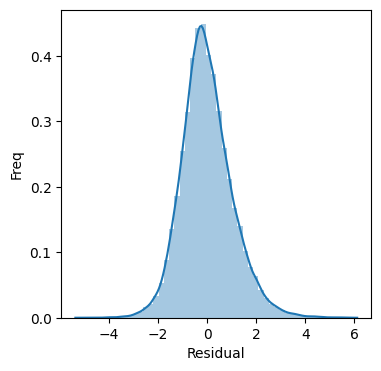

In [229]:
res=test_data['res']
plt.figure(figsize = (4,4))
sns.distplot(res)
plt.xlabel("Residual")
plt.ylabel("Freq")
plt.show()
plt.show()


The distribution of residual here is symmetrically distribution with 0 as center.(Absolute value of skewness is small.)

Most residuals are in [-2,2] interval.

* **Scatter of prediction on test set**

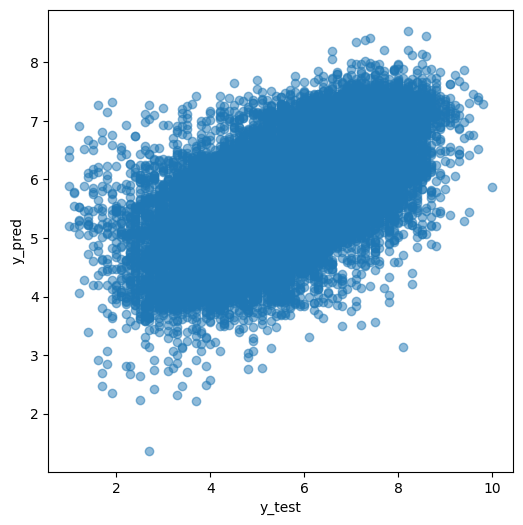

In [230]:
plt.figure(figsize = (6,6))
plt.scatter(np.array(y_test), y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

 **Feature importance**

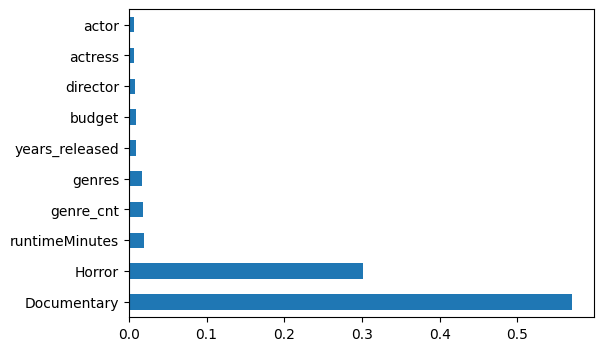

In [221]:
#generate top 10 important features
plt.figure(figsize = (6,4))
importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.show()

Four **nummerical features** a positively correlated to movie rating.
* **Budget**:From the previous assumption, movie rating is as estimate of its quality, whereas budget have a direct impact on it. the more money the production team raised, the better movie they can make.
* **Genre_cnt**: the more genres a movie involve, the more diverse a movie is. It seems movies containing multiple genres are relatively preferred.
* **Year_released**: people are moving better movies over time, learning from the post.
* **Running_minute**: It's surprising that the longer a movie is, the popular it is. But that makes sense: only a few movies have long duration (according to our EDA), and we can recall many great movies with long durations such as 《Titanic》and 《Once Upon a Time in America》. Also recall two version of 《Justice League》(2017) and 《Zack Snyder's Justice League》(2021). You never want to force a director cut movie into shorter version.

For **categorical features**:
* **Genre-related**:

  horroe movies have relatively low rating where documentary relatively have high rating. An intuition: low budget lead to low movie quality. Many horror movie is low-budget, whereas documentary movies are always well-crafted to convey history with enough budget raised from public and government. Movies'genres have a great impact on rating.

*  **Time-realted**:

  As revealed before in EDA, movie rating slightly increase by production era.  It's intuitive since people have been making slow progress year by year on movie production.

* **People-related**:

  we used frequency encoding for those categorical features. After encoding, those features can reveal how many movies a member engaged in production. Our assumption is that excellent directors, actors, actress, etc., are more likely to be invite by movie company for production, and those features can measure the excellence of prodction team.

   **This conclusions above accord with our assumption well!**

**Insight**

* The importance of "budget" feature can quantify the improve of movie quality brought by unit budget;
* Movies that involved more than one genre, which may attain more asethetic values and diversity, are preferred by audience.
* Mainstream asethetic fondness for different genres of movies is different; it seems people tend to like documentary movies and dislike horror movies.
* It's still hard to say people prefer long movies than short once. There exist association between duration and rating, but it might not be causation. There might be counfounding. For exanpme, long movies often raised enough budget, or dierctors would be more devoted when they want to make long movies.

* Accord with intuition, with development of movie tech, movie art, people keep making progress on movie production all time, which slowly push to produce movies with high quality. However, this correlation can be disturbed by external environment under certain eras.

* Great people create great things -  that is same for movie, generally speaking. Directors, actors, actress who is more capable of making high-quality movies would become moew famous and receive more movie production invites.

# Future Work

**Data Collection**

* Scrap movie post and create image features using computer vision. This feature could directly reveal its asethetic value and produced era.
* Scrap of content-related information of a movie (wiki, script, etc...). Script and content has direct impacts on movie quality.
* Scarp social media information of production team members, such as fans level. This could reveal how popular the production team members are.

**Modeling**

* In this work I used regression for modeling. However, we can also use classification model to predict movie ratings from 1 to 10, but need to solve balance imbalance issue.

* Try recursive method for feature selection and model training

* Try more sophisticated models like neural networks model.

* Try parameter tuning for other ensemble model as well if given unlimited time

* Try different parameter tuning method (grid search, bayesian optimization, etc.)

* Of course, given more time, try more number of interations for model fine tunning

* Some causal methods might be helpful in building this model.

# Reference

[XGBoost doc](https://xgboost.readthedocs.io/en/latest/index.html)

[LGBM doc](https://lightgbm.readthedocs.io/en/latest/index.html)


[Predicting IMDB Movie Ratings Using Social Media](https://www.researchgate.net/publication/262401833_Predicting_IMDB_Movie_Ratings_Using_Social_Media)

[IMDb Datasets](https://developer.imdb.com/non-commercial-datasets/)

[TMDd Datasets](https://developer.themoviedb.org/docs/getting-started)(To scrap extra data)

# Appendix

* **Scarping movie data from TMDB**

In [231]:
'''import requests
import json
import traceback
import unicodedata

IDs = []
key='01b66b0c855262aeead63f9b48cddcf3'# Api key
json_list = []
error_list = []
tmdb_IDs=list(set(movie_.tconst))
print(len(tmdb_IDs))
for tmdb_ID in tmdb_IDs:
    url = 'https://api.themoviedb.org/3/movie/{}?api_key={}&language=en-US'.format(tmdb_ID,key)
    response = requests.get(url)
    try:
        json_list.append(response.json())
    except:
        error_list.append(tmdb_ID,traceback.format_exc())
        print(tmdb_ID,traceback.format_exc())
tmdb_df = pd.DataFrame(json_list)
tmdb_df.to_csv('/content/drive/MyDrive/IMDB/tmdb.csv', index=False)
'''
#ps: would take hours

"import requests\nimport json\nimport traceback\nimport unicodedata\n \nIDs = []\nkey='01b66b0c855262aeead63f9b48cddcf3'# Api key\njson_list = []\nerror_list = []\ntmdb_IDs=list(set(movie_.tconst))\nprint(len(tmdb_IDs))\nfor tmdb_ID in tmdb_IDs:\n    url = 'https://api.themoviedb.org/3/movie/{}?api_key={}&language=en-US'.format(tmdb_ID,key)\n    response = requests.get(url)\n    try:\n        json_list.append(response.json())\n    except:\n        error_list.append(tmdb_ID,traceback.format_exc())\n        print(tmdb_ID,traceback.format_exc())\ntmdb_df = pd.DataFrame(json_list)\ntmdb_df.to_csv('/content/drive/MyDrive/IMDB/tmdb.csv', index=False)\n"

* **A visualized causation DAG regarding movie rating**

<Figure size 1500x1500 with 0 Axes>

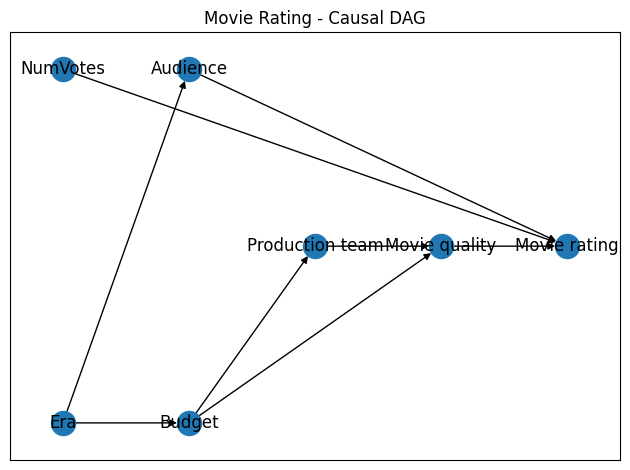

In [241]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize = (15,15))
G = nx.DiGraph(
    [

        ("Audience", "Movie rating"),
        ("Movie quality", "Movie rating"),
        ("NumVotes", "Movie rating"),
        ("Production team", "Movie quality"),
        ("Budget", "Movie quality"),
        ("Budget", "Production team"),
        ("Era", "Budget"),
        ("Era", "Audience")


    ]
)
for layer, nodes in enumerate(nx.topological_generations(G)):

    for node in nodes:
        G.nodes[node]["layer"] = layer
pos = nx.multipartite_layout(G, subset_key="layer")
fig, ax = plt.subplots()
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title("Movie Rating - Causal DAG")
fig.tight_layout()
plt.show()